# 필요한 패키지 로딩

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz

# 파일 불러오기

In [2]:
fifa = pd.read_excel('C:/K_digital/source/data/FIFA_BIGLEAGUE.xlsx')

In [3]:
fifa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2976 entries, 0 to 2975
Data columns (total 48 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   sofifa_id                    2976 non-null   object
 1   REG/SUB/RES                  2976 non-null   object
 2   club_position                2976 non-null   object
 3   overall                      2976 non-null   int64 
 4   potential                    2976 non-null   int64 
 5   height_cm                    2976 non-null   int64 
 6   weight_kg                    2976 non-null   int64 
 7   pace                         2976 non-null   int64 
 8   shooting                     2976 non-null   int64 
 9   passing                      2976 non-null   int64 
 10  dribbling                    2976 non-null   int64 
 11  defending                    2976 non-null   int64 
 12  physic                       2976 non-null   int64 
 13  attacking_crossing           2976

## 새로 속성을 만들어서 정수형 범주 만들기

In [4]:
target = []
for i in fifa.iloc[:,1]:
    if i == 'REG': # 주전선수
        target.append(0)
    elif i == 'SUB': # 후보선수(벤치)
        target.append(1)
    elif i == 'RES': # 1군(벤치제외)
        target.append(2)
fifa['target'] = target

In [5]:
fifa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2976 entries, 0 to 2975
Data columns (total 49 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   sofifa_id                    2976 non-null   object
 1   REG/SUB/RES                  2976 non-null   object
 2   club_position                2976 non-null   object
 3   overall                      2976 non-null   int64 
 4   potential                    2976 non-null   int64 
 5   height_cm                    2976 non-null   int64 
 6   weight_kg                    2976 non-null   int64 
 7   pace                         2976 non-null   int64 
 8   shooting                     2976 non-null   int64 
 9   passing                      2976 non-null   int64 
 10  dribbling                    2976 non-null   int64 
 11  defending                    2976 non-null   int64 
 12  physic                       2976 non-null   int64 
 13  attacking_crossing           2976

## 각 feature 별 상관계수 보기

In [6]:
fifa.iloc[:,3:48].corrwith(fifa.iloc[:,48])

overall                       -0.662148
potential                     -0.366521
height_cm                     -0.017219
weight_kg                     -0.112699
pace                          -0.125420
shooting                      -0.211779
passing                       -0.249294
dribbling                     -0.215244
defending                     -0.229331
physic                        -0.243517
attacking_crossing            -0.261610
attacking_finishing           -0.208022
attacking_heading_accuracy    -0.246851
attacking_short_passing       -0.345708
attacking_volleys             -0.222132
skill_dribbling               -0.240296
skill_curve                   -0.257833
skill_fk_accuracy             -0.224023
skill_long_passing            -0.346522
skill_ball_control            -0.295200
movement_acceleration         -0.160334
movement_sprint_speed         -0.182726
movement_agility              -0.192104
movement_reactions            -0.606745
movement_balance              -0.117082


- 골키퍼의 스탯은 일반 필드플레이어와 달라 분류하기 힘들기에 제외하기로 함

In [7]:
# 클럽포지션에 GK가 포함된 인덱스를 gk 변수에 담음
gk = fifa[fifa['club_position'].str.contains('GK')].index
# drop 함수로 골키퍼 데이터만 삭제, inplace로 따로 변수에 저장할 필요없이 바로 적용)
fifa.drop(gk, inplace=True)

In [8]:
fifa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2878 entries, 0 to 2975
Data columns (total 49 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   sofifa_id                    2878 non-null   object
 1   REG/SUB/RES                  2878 non-null   object
 2   club_position                2878 non-null   object
 3   overall                      2878 non-null   int64 
 4   potential                    2878 non-null   int64 
 5   height_cm                    2878 non-null   int64 
 6   weight_kg                    2878 non-null   int64 
 7   pace                         2878 non-null   int64 
 8   shooting                     2878 non-null   int64 
 9   passing                      2878 non-null   int64 
 10  dribbling                    2878 non-null   int64 
 11  defending                    2878 non-null   int64 
 12  physic                       2878 non-null   int64 
 13  attacking_crossing           2878

In [9]:
# 상관계수 재확인(골키퍼 스탯은 이제 필요없기에 제외)
fifa.iloc[:,3:42].corrwith(fifa.iloc[:,48])

overall                       -0.655472
potential                     -0.357626
height_cm                      0.030943
weight_kg                     -0.071909
pace                          -0.261836
shooting                      -0.335945
passing                       -0.404776
dribbling                     -0.371234
defending                     -0.343170
physic                        -0.402000
attacking_crossing            -0.375251
attacking_finishing           -0.297000
attacking_heading_accuracy    -0.372255
attacking_short_passing       -0.471993
attacking_volleys             -0.312442
skill_dribbling               -0.370685
skill_curve                   -0.360555
skill_fk_accuracy             -0.310652
skill_long_passing            -0.447021
skill_ball_control            -0.434983
movement_acceleration         -0.228905
movement_sprint_speed         -0.256098
movement_agility              -0.259868
movement_reactions            -0.603831
movement_balance              -0.186624


다 하고 나니 왜 한건지 모르겠음
결정나무를 사용할거면 상관계수는 필요없을텐데 괜히 한거 같음.

## DecisionTreeClassifier를 사용하기 위한 전처리

In [10]:
# Numpy 배열로 변환
stat = fifa.iloc[:,3:39].to_numpy()
target = fifa.iloc[:,48].to_numpy()

In [11]:
X_train, X_test, y_train, y_test = train_test_split(stat, target, random_state=2022)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2158, 36), (720, 36), (2158,), (720,))

# DecisionTreeClassifier

In [12]:
dt = DecisionTreeClassifier(random_state=2022)
dt.fit(X_train, y_train)


DecisionTreeClassifier(random_state=2022)

## 1차 시각화

In [13]:
from sklearn.tree import export_graphviz

# export_graphviz(모델객체, 출력파일명, 결정트리클래스명칭, 결정트리피쳐명칭)
export_graphviz(dt, out_file='tree.dot', class_names=fifa.iloc[:,1].unique(),
               feature_names=fifa.iloc[:,3:39].columns, impurity=True, filled=True)

In [14]:
import graphviz
# open(filename, mode)
# mode : r(default), w, a
with open('tree.dot') as f:
    dot_graph = f.read()
    
src = graphviz.Source(dot_graph)

In [15]:
src.view()

'Source.gv.pdf'

## 결정계수 확인

In [16]:
print(dt.score(X_train, y_train))
print(dt.score(X_test, y_test))

1.0
0.48333333333333334


In [17]:
fifa.iloc[:,3:42].columns

Index(['overall', 'potential', 'height_cm', 'weight_kg', 'pace', 'shooting',
       'passing', 'dribbling', 'defending', 'physic', 'attacking_crossing',
       'attacking_finishing', 'attacking_heading_accuracy',
       'attacking_short_passing', 'attacking_volleys', 'skill_dribbling',
       'skill_curve', 'skill_fk_accuracy', 'skill_long_passing',
       'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed',
       'movement_agility', 'movement_reactions', 'movement_balance',
       'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength',
       'power_long_shots', 'mentality_aggression', 'mentality_interceptions',
       'mentality_positioning', 'mentality_vision', 'mentality_penalties',
       'mentality_composure', 'defending_marking_awareness',
       'defending_standing_tackle', 'defending_sliding_tackle'],
      dtype='object')

In [18]:
dt.feature_importances_

array([0.25162294, 0.02703353, 0.02173885, 0.02400411, 0.00730648,
       0.0070236 , 0.00826238, 0.01505744, 0.01857739, 0.02066732,
       0.0161812 , 0.01207623, 0.02887167, 0.01907139, 0.01840578,
       0.03472015, 0.0409107 , 0.01841229, 0.02434113, 0.01004832,
       0.02202072, 0.0195752 , 0.01733673, 0.02259581, 0.01370927,
       0.0238874 , 0.03077825, 0.05349522, 0.01109381, 0.0297902 ,
       0.01241462, 0.01863804, 0.02606308, 0.01808082, 0.03382653,
       0.02236143])

과적합이 일어났기에 하이퍼 파라미터 설정을 위해 그리드 서치 사용하기

## 그리드 서치

In [21]:
from sklearn.model_selection import GridSearchCV
model = DecisionTreeClassifier(random_state = 2022)

arrmd = []
for i in range(2, 30):
    arrmd.append(i)

arrmsl = []
for i in range(1, 20):
    arrmsl.append(i)

arrmss = []
for i in range(2, 100):
    arrmss.append(i)

arrmd.append(None)

params = {
    'max_depth':arrmd,
    'min_samples_leaf':arrmsl,
    'min_samples_split':arrmss
}

gs = GridSearchCV(model, param_grid = params, cv = 5, refit = True, n_jobs=-1)
gs.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=2022),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                       14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
                                       24, 25, 26, 27, 28, 29, None],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19],
                         'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                               12, 13, 14, 15, 16, 17, 18, 19,
                                               20, 21, 22, 23, 24, 25, 26, 27,
                                               28, 29, 30, 31, ...]})

In [22]:
model = gs.best_estimator_
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.6872103799814643
0.5638888888888889


In [23]:
print(gs.best_params_)

{'max_depth': 7, 'min_samples_leaf': 14, 'min_samples_split': 76}


In [24]:
print(gs.best_score_)

0.6195647503652144


In [25]:
np.max(gs.cv_results_['mean_test_score'])

0.6195647503652144

In [27]:
model = DecisionTreeClassifier(max_depth = 7, random_state = 2022,
                               min_samples_leaf = 14, min_samples_split = 76)
model.fit(X_train, y_train)
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.6872103799814643
0.5638888888888889


In [28]:
export_graphviz(model, out_file='gridtree.dot', class_names=fifa.iloc[:,1].unique(),
               feature_names=fifa.iloc[:,3:39].columns, impurity=True, filled=True)

In [32]:
with open('gridtree.dot') as f:
    dot_graph = f.read()
    
src = graphviz.Source(dot_graph)

In [34]:
src.view()

'Source.gv.pdf'

# 주전(REG)만 분리

- 좌측 윙백과 우측 공미가 1명씩 뿐이고 다른 데이터도 적은게 있어서 재분류하기로 함(엑셀로)
    - 'SW' : 0
    - 'ST' : 1
    - 'CM' : 2
    - 'DM' : 3
    - 'CB' : 4
    - 'AM' : 5
    - 'SB' : 6
    - 'SM' : 7

In [35]:
# 주전구분에 SUB가 포함된 인덱스를 sub 변수, RES가 포함된 인덱스를 res 변수에 담음
sub = fifa[fifa['REG/SUB/RES'].str.contains('SUB')].index
res = fifa[fifa['REG/SUB/RES'].str.contains('RES')].index
# drop 함수로 SUB 데이터만 삭제, inplace로 따로 변수에 저장할 필요없이 바로 적용)
fifa.drop(sub, inplace=True)
fifa.drop(res, inplace=True)
fifa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 980 entries, 0 to 2657
Data columns (total 49 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   sofifa_id                    980 non-null    object
 1   REG/SUB/RES                  980 non-null    object
 2   club_position                980 non-null    object
 3   overall                      980 non-null    int64 
 4   potential                    980 non-null    int64 
 5   height_cm                    980 non-null    int64 
 6   weight_kg                    980 non-null    int64 
 7   pace                         980 non-null    int64 
 8   shooting                     980 non-null    int64 
 9   passing                      980 non-null    int64 
 10  dribbling                    980 non-null    int64 
 11  defending                    980 non-null    int64 
 12  physic                       980 non-null    int64 
 13  attacking_crossing           980 n

In [36]:
fifa.club_position.unique()

array(['SW', 'ST', 'CM', 'DM', 'CB', 'AM', 'SB', 'SM'], dtype=object)

In [37]:
target = []
for i in fifa.iloc[:,2]:
    if i == 'SW': # 사이드윙
        target.append(0)
    elif i == 'ST': # 스트라이커
        target.append(1)
    elif i == 'CM': # 중앙미드필더
        target.append(2)
    elif i == 'DM': # 수비형미드필더
        target.append(3)
    elif i == 'CB': # 센터백
        target.append(4)
    elif i == 'AM': # 공격형미드필더
        target.append(5)
    elif i == 'SB': # 사이드백
        target.append(6)
    elif i == 'SM': # 사이드미드필더
        target.append(7)

fifa['target'] = target

In [38]:
stat = fifa.iloc[:,3:42].to_numpy()
target = fifa.iloc[:,48].to_numpy()

In [39]:
X_train, X_test, y_train, y_test = train_test_split(stat, target, random_state=2022)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((735, 39), (245, 39), (735,), (245,))

In [40]:
fifa.iloc[:,48].value_counts()

4    224
6    166
1    147
2    136
7    128
3     96
5     43
0     40
Name: target, dtype: int64

# 변수가 많기에 바로 그리드 서치로

In [41]:
model = DecisionTreeClassifier(random_state = 2022)

arrmd = []
for i in range(2, 30):
    arrmd.append(i)

arrmsl = []
for i in range(1, 20):
    arrmsl.append(i)

arrmss = []
for i in range(2, 100):
    arrmss.append(i)

arrmd.append(None)

params = {
    'max_depth':arrmd,
    'min_samples_leaf':arrmss,
    'min_samples_split':arrmss
}

gs = GridSearchCV(model, param_grid = params, cv = 5, refit = True, n_jobs=-1)
gs.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=2022),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                       14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
                                       24, 25, 26, 27, 28, 29, None],
                         'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19,
                                              20, 21, 22, 23, 24, 25, 26, 27,
                                              28, 29, 30, 31, ...],
                         'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                               12, 13, 14, 15, 16, 17, 18, 19,
                                               20, 21, 22, 23, 24, 25, 26, 27,
                                               28, 29, 30, 31, ...]})

In [42]:
model = gs.best_estimator_
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.6625850340136055
0.5265306122448979


In [43]:
print(gs.best_params_)

{'max_depth': 4, 'min_samples_leaf': 18, 'min_samples_split': 56}


In [44]:
print(gs.best_score_)

0.6408163265306122


In [45]:
np.max(gs.cv_results_['mean_test_score'])

0.6408163265306122

In [46]:
model = DecisionTreeClassifier(max_depth = 3, random_state = 2022,
                               min_samples_leaf = 6, min_samples_split = 2)
model.fit(X_train, y_train)
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))
# 타겟 종류가 많아져서 그런지 적중률 더욱 하락
# 하지만 프로그램 해석에 따라 재해석은 가능
# 이 선수는 이러한 포지션이 더 적절하나 다른 포지션으로 뛰고있다라는 느낌
# 하지만 당연히 과대적합을 의심해보아야 하기에 시각화 후 최근접 분류로 넘어감

0.6272108843537415
0.5020408163265306


# 최근접 분류

In [56]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)

In [57]:
knn.fit(X_train, y_train)
knn.score(X_train, y_train)

0.7945578231292517

In [58]:
knn.score(X_test, y_test)

0.6122448979591837

In [63]:
from sklearn.metrics import accuracy_score

ks = 100
mean_acc_train = np.zeros((ks-1))
mean_acc_test = np.zeros((ks-1))

for k in range(1, ks):
    clf = KNeighborsClassifier(n_neighbors = k).fit(X_train, y_train)
    yhat = clf.predict(X_train)
    mean_acc_train[k-1] = accuracy_score(y_train, yhat)
    yhat = clf.predict(X_test)
    mean_acc_test[k-1] = accuracy_score(y_test, yhat)
    
print(mean_acc_test)

[0.63265306 0.5755102  0.6122449  0.57959184 0.59591837 0.58367347
 0.60408163 0.60408163 0.6122449  0.62857143 0.61632653 0.60816327
 0.61632653 0.61632653 0.6244898  0.60816327 0.60816327 0.61632653
 0.6244898  0.62857143 0.63673469 0.62857143 0.63265306 0.6244898
 0.6122449  0.59183673 0.59591837 0.60408163 0.60408163 0.60816327
 0.59591837 0.61632653 0.60408163 0.61632653 0.6122449  0.60408163
 0.6        0.61632653 0.61632653 0.60816327 0.61632653 0.60816327
 0.6122449  0.61632653 0.61632653 0.6244898  0.6122449  0.61632653
 0.62040816 0.60408163 0.6244898  0.60408163 0.59183673 0.59183673
 0.59183673 0.5755102  0.6        0.62040816 0.61632653 0.61632653
 0.61632653 0.6122449  0.60408163 0.60408163 0.6        0.60816327
 0.59183673 0.59183673 0.59591837 0.59183673 0.59591837 0.59591837
 0.59183673 0.59183673 0.58367347 0.58367347 0.57959184 0.57959184
 0.5877551  0.57959184 0.5755102  0.58367347 0.58367347 0.58367347
 0.58367347 0.5877551  0.5877551  0.5877551  0.5877551  0.58367

In [64]:
print(mean_acc_train)

[1.         0.79047619 0.79455782 0.76326531 0.76326531 0.74693878
 0.73877551 0.73061224 0.73197279 0.72380952 0.72653061 0.72380952
 0.72380952 0.71156463 0.70748299 0.70612245 0.71292517 0.70748299
 0.70340136 0.70204082 0.70340136 0.69931973 0.6952381  0.68979592
 0.69115646 0.69115646 0.68707483 0.68979592 0.69387755 0.69387755
 0.6952381  0.68843537 0.68707483 0.68571429 0.68027211 0.6829932
 0.68571429 0.68571429 0.6829932  0.68979592 0.68571429 0.69251701
 0.69251701 0.6952381  0.6829932  0.68843537 0.68707483 0.68571429
 0.67755102 0.68435374 0.67891156 0.67755102 0.67891156 0.67755102
 0.67891156 0.68435374 0.68163265 0.68163265 0.68163265 0.67482993
 0.68027211 0.67755102 0.67619048 0.67210884 0.6707483  0.66938776
 0.66802721 0.67210884 0.66802721 0.66938776 0.66394558 0.66938776
 0.66530612 0.66938776 0.66666667 0.66666667 0.66530612 0.66394558
 0.66394558 0.66666667 0.66258503 0.66122449 0.66530612 0.66258503
 0.66122449 0.65986395 0.66258503 0.66122449 0.66122449 0.65986

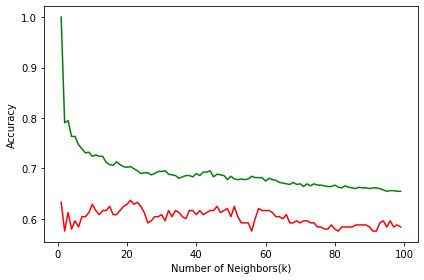

In [65]:
plt.plot(range(1, ks), mean_acc_train, 'g')
plt.plot(range(1, ks), mean_acc_test, 'r')
plt.xlabel('Number of Neighbors(k)')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()

In [67]:
mean_acc_train - mean_acc_test

array([0.36734694, 0.21496599, 0.18231293, 0.18367347, 0.16734694,
       0.16326531, 0.13469388, 0.12653061, 0.11972789, 0.0952381 ,
       0.11020408, 0.11564626, 0.10748299, 0.0952381 , 0.0829932 ,
       0.09795918, 0.1047619 , 0.09115646, 0.07891156, 0.07346939,
       0.06666667, 0.0707483 , 0.06258503, 0.06530612, 0.07891156,
       0.09931973, 0.09115646, 0.08571429, 0.08979592, 0.08571429,
       0.09931973, 0.07210884, 0.0829932 , 0.06938776, 0.06802721,
       0.07891156, 0.08571429, 0.06938776, 0.06666667, 0.08163265,
       0.06938776, 0.08435374, 0.08027211, 0.07891156, 0.06666667,
       0.06394558, 0.07482993, 0.06938776, 0.05714286, 0.08027211,
       0.05442177, 0.07346939, 0.08707483, 0.08571429, 0.08707483,
       0.10884354, 0.08163265, 0.06122449, 0.06530612, 0.0585034 ,
       0.06394558, 0.06530612, 0.07210884, 0.06802721, 0.0707483 ,
       0.06122449, 0.07619048, 0.08027211, 0.07210884, 0.07755102,
       0.06802721, 0.07346939, 0.07346939, 0.07755102, 0.08299

In [69]:
# 59번째 인덱스에서 값차이가 제일 적음
mean_acc_train[59] - mean_acc_test[59]

0.058503401360544216

In [71]:
print(mean_acc_train[59],'/', mean_acc_test[59])

0.6748299319727891 / 0.6163265306122448


In [ ]:
# 의사결정 나무보다 과대적합은 줄어듬
# 하지만 여전히 결정계수가 낮음
# 혹시나 올라갈까 싶어서 로지스틱 회귀로 넘어감

# 로지스틱 회귀

In [83]:
fifa.iloc[:,3:42].corrwith(fifa.iloc[:,48])

overall                       -0.124824
potential                     -0.107988
height_cm                     -0.145689
weight_kg                     -0.150323
pace                           0.169290
shooting                      -0.280286
passing                       -0.032230
dribbling                     -0.108107
defending                      0.279905
physic                        -0.085963
attacking_crossing             0.198964
attacking_finishing           -0.290039
attacking_heading_accuracy    -0.186139
attacking_short_passing       -0.136015
attacking_volleys             -0.281361
skill_dribbling               -0.092093
skill_curve                   -0.030395
skill_fk_accuracy             -0.118857
skill_long_passing            -0.011372
skill_ball_control            -0.179854
movement_acceleration          0.159674
movement_sprint_speed          0.164826
movement_agility               0.026847
movement_reactions            -0.184247
movement_balance               0.049394


In [84]:
fifa_corr = fifa.iloc[:,3:42].corrwith(fifa.iloc[:,48])

In [85]:
type(fifa_corr)

pandas.core.series.Series

In [96]:
# 상관계수 절대값이 0.25 이상인 인덱스를 구함
lr_fifa = fifa_corr[lambda x : abs(x)>=0.25].index

In [97]:
fifa[lr_fifa]

,shooting,defending,attacking_finishing,attacking_volleys,mentality_interceptions,mentality_penalties,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle
0,92,34,95,88,40,75,20,35,24
1,92,44,95,89,49,90,35,42,19
2,94,34,95,86,29,88,24,32,24
3,83,37,83,86,37,93,35,32,29
4,86,64,82,82,66,83,68,65,53
...,...,...,...,...,...,...,...,...,...
2496,52,65,49,55,63,46,65,69,67
2508,34,63,31,35,57,46,56,75,72
2597,31,54,26,20,53,39,55,57,54
2641,46,56,46,41,58,41,53,58,57


In [98]:
stat = fifa[lr_fifa].to_numpy()
target = fifa.iloc[:,2].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(stat, target, random_state=2022)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((735, 9), (245, 9), (735,), (245,))

In [105]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=20, max_iter=1000)
lr.fit(X_train, y_train)

C:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=20, max_iter=1000)

In [106]:
lr.predict(X_train[:5])

array(['CB', 'CB', 'SM', 'CB', 'SB'], dtype=object)

In [107]:
lr.classes_

array(['AM', 'CB', 'CM', 'DM', 'SB', 'SM', 'ST', 'SW'], dtype=object)

In [108]:
proba = lr.predict_proba(X_train[:5])
np.round(proba, decimals=3)

array([[0.   , 0.905, 0.004, 0.011, 0.079, 0.001, 0.   , 0.   ],
       [0.   , 0.997, 0.   , 0.   , 0.003, 0.   , 0.   , 0.   ],
       [0.129, 0.   , 0.149, 0.024, 0.   , 0.382, 0.1  , 0.216],
       [0.   , 0.848, 0.021, 0.032, 0.099, 0.   , 0.   , 0.   ],
       [0.006, 0.001, 0.163, 0.164, 0.626, 0.039, 0.001, 0.   ]])

In [109]:
print(lr.score(X_train, y_train))
print(lr.score(X_test, y_test))

0.6517006802721088
0.5551020408163265
